
# Project: Investigate a Dataset (No Show Appointments)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## Introduction

>This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
‘ScheduledDay’ tells us on what day the patient set up their appointment. ‘Neighborhood’ indicates the location of the hospital. ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família. Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

## Questions
- Are there any trends between day of the week of the scheduled-appointment date and the No-Show rates?
- Are there any trends between SMS_received and the no-show rates?

In [71]:
#Importing packages

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.stats.proportion
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import table
%matplotlib inline


## Data Wrangling

### General Properties

In [152]:
# read dataSet
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [73]:
# summary of the dataSet
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [74]:
# statistical details of dataSet
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [75]:
# The shape of dataSet (rows and columns)
df.shape

(110527, 14)

In [76]:
# counts of unique values in "No-show" column
df["No-show"].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [77]:
# make both yes and no in separated dataFrmaes so that i can find the trends 
df_yes= df[df["No-show"]=="Yes"]
df_no= df[df["No-show"]=="No"]

In [78]:
# how many "yes" with sms received and with not sms-recieved
df_yes["SMS_received"].value_counts()

0    12535
1     9784
Name: SMS_received, dtype: int64

In [79]:
# how many "no" with sms received and with not sms-recieved
df_no["SMS_received"].value_counts()

0    62510
1    25698
Name: SMS_received, dtype: int64

In [153]:
# change the'ScheduledDay' and 'AppointmentDay' datatypes to datatime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [154]:
# Extract days of week an hours from 'ScheduledDay' column
df['WeekDays'] = df['ScheduledDay'].dt.weekday_name
df['Hours'] = df['ScheduledDay'].dt.hour

In [82]:
# show sample of dataSet
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WeekDays,Hours
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,18
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,16
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,16
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,17
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,16


In [83]:
# counts of unique values in "WeekDays" column
df["WeekDays"].value_counts()

Tuesday      26168
Wednesday    24262
Monday       23085
Friday       18915
Thursday     18073
Saturday        24
Name: WeekDays, dtype: int64

In [84]:
# how many "yes" and "no" with Tuesday
df_Tuesday=df[df["WeekDays"]=="Tuesday"]
df_Tuesday["No-show"].value_counts()

No     20877
Yes     5291
Name: No-show, dtype: int64

In [85]:
# how many "yes" and "no" with Wednesday
df_Wednesday=df[df["WeekDays"]=="Wednesday"]
df_Wednesday["No-show"].value_counts()

No     19383
Yes     4879
Name: No-show, dtype: int64

In [86]:
# how many "yes" and "no" with Monday
df_Monday=df[df["WeekDays"]=="Monday"]
df_Monday["No-show"].value_counts()

No     18524
Yes     4561
Name: No-show, dtype: int64

In [87]:
# how many "yes" and "no" with Friday
df_Friday=df[df["WeekDays"]=="Friday"]
df_Friday["No-show"].value_counts()

No     15028
Yes     3887
Name: No-show, dtype: int64

In [67]:
# how many "yes" and "no" with Thursday
df_Thursday=df[df["WeekDays"]=="Thursday"]
df_Thursday["No-show"].value_counts()

No     14373
Yes     3700
Name: No-show, dtype: int64

### Data Cleaning (Exclude the extreme values in Age and Hours columns)

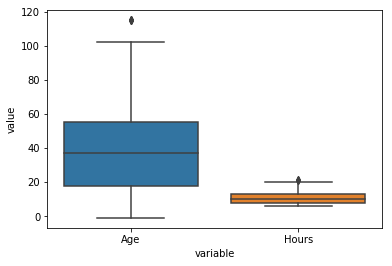

In [102]:
# draw boxplot for age and hours columns before removing the extreme values
df_boxplot = pd.DataFrame(data = df, columns = ['Age','Hours'])

sns.boxplot(x="variable", y="value", data=pd.melt(df_boxplot))

plt.show()

In [123]:
# Exploring the extreme and wrong values in Age column 
df["Age"].value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
 56     1635
 38     1629
 59     1624
 2      1618
 50     1613
 57     1603
 36     1580
 51     1567
 19     1545
 39     1536
 37     1533
 54     1530
 34     1526
 33     1524
 30     1521
 6      1521
 3      1513
 17     1509
 32     1505
 5      1489
 44     1487
 18     1487
 58     1469
 46     1460
 45     1453
        ... 
 74      602
 76      571
 75      544
 78      541
 77      527
 80      511
 81      434
 82      392
 79      390
 84      311
 83      280
 85      275
 86      260
 87      184
 89      173
 88      126
 90      109
 92       86
 91       66
 93       53
 94       33
 95       24
 96       17
 97       11
 98        6
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

In [156]:
# remove the rows with age equal -1 and age more than 97
df=df[df["Age"] > -1]
df=df[df["Age"] < 98]


In [124]:
# Exploring the extreme and wrong values in Hours column 
df["Hours"].value_counts()

7     19213
8     15349
9     12823
10    11056
14     9127
13     9036
11     8462
15     8079
16     5542
12     5422
17     2909
6      1578
18     1340
19      488
20      100
21        3
Name: Hours, dtype: int64

In [157]:
# remove the rows with Hours equal 21
df=df[df["Hours"] < 21]

In [129]:
df["WeekDays"].value_counts()

Tuesday      26168
Wednesday    24262
Monday       23085
Friday       18915
Thursday     18073
Saturday        24
Name: WeekDays, dtype: int64

In [159]:
# remove the rows with WeekDays equal Saturday
indexNames = df[ df['WeekDays'] == "Saturday" ].index
df.drop(indexNames , inplace=True)

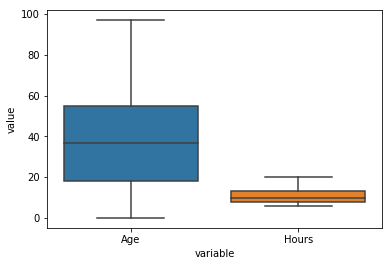

In [161]:
# draw boxplot for age and hours columns after removing the extreme values
cleaned_df_boxplot = pd.DataFrame(data = df, columns = ['Age','Hours'])

sns.boxplot(x="variable", y="value", data=pd.melt(cleaned_df_boxplot))

plt.show()

## Exploratory Data Analysis


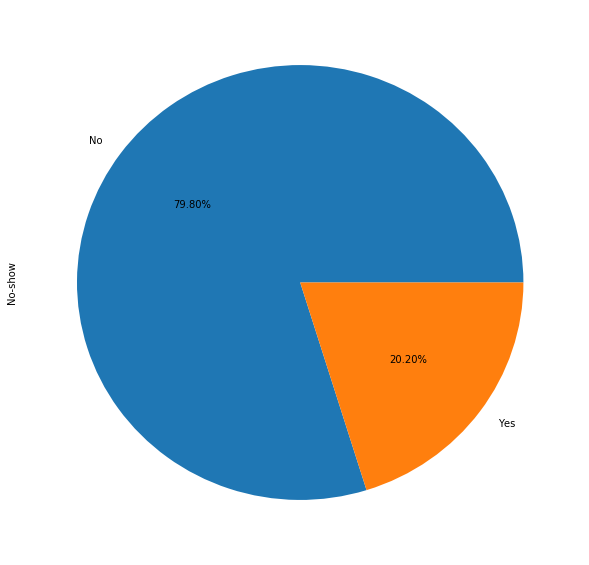

In [171]:
# Exploring the percentage of "yes" and "no" using pie chart
df["No-show"].value_counts().plot.pie(figsize=(10,10), autopct='%.2f%%')
plt.show()

#### Just over 20% went to the appointments and more than 79% didn't go to the appointments 




### Research Question 1 (Are there any trends between day of the week of the scheduled-appointment date and the No-Show rates?)

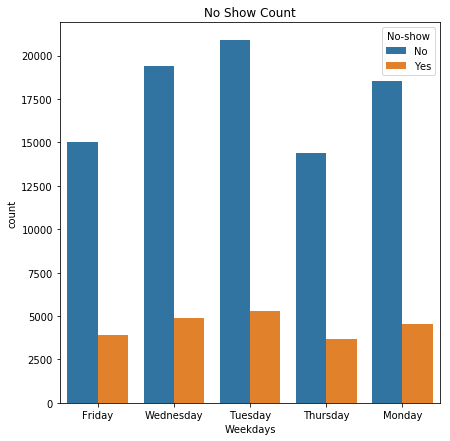

In [173]:
# Exploring the trend of "yes" and "no" with days of week using bar graph
figure = plt.figure(figsize=(15,7))
xx = figure.add_subplot(1,2,1)
xx.set_title("No Show Count")
sns.countplot(x="WeekDays",hue="No-show",data=df,ax=xx)
xx.set_xlabel("Weekdays")
plt.show()

#### It's clear that the percentage of no-show is not related to days of week

### Research Question 2  (Are there any trends between SMS_received and the no-show rates?)

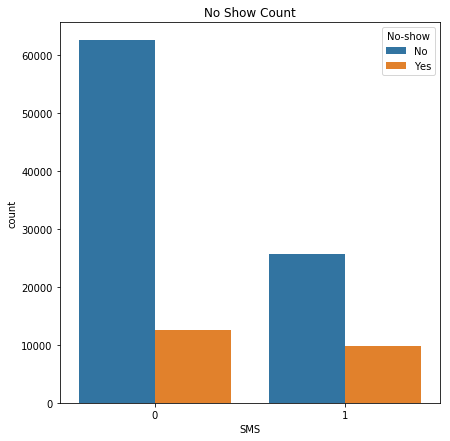

In [175]:
# Exploring the trend of "yes" and "no" with SMS-received using bar graph
figure = plt.figure(figsize=(15,7))
xx = figure.add_subplot(1,2,1)
xx.set_title("No Show Count")
sns.countplot(x="SMS_received",hue="No-show",data=df,ax=xx)
xx.set_xlabel("SMS")
plt.show()


#### It is clear that the percentage of going to the appointments is much higher when SMS messages were received

## Conclusions

### - After loaded the dataset and explored the counts of many features and figured out the trend between SMS_received and no-show appointments and extract the days of week to explore if there is trend with the no-show and extract the hours to exclude the extreme values.

### - The values less than 0 and more than 97 have been excluded of Age column , the saturday has been excluded and it is only 24 day and the extreme values of hours which i equal 21 have been excluded and it's only 3 rows .

### - Obviously from the charts above there is no trend between days of the week and no-shows but its very clear between sms and no-shows.